In [2]:
import numpy as np
import pandas as pd

from sklearn.datasets import fetch_covtype
from sklearn.model_selection import train_test_split
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.inspection import DecisionBoundaryDisplay
from sklearn.model_selection import GridSearchCV

import seaborn as sns
import regex as re

In [3]:
X, y = fetch_covtype(as_frame=True, return_X_y=True)

In [4]:
# splitting into train and test using a stratified split 
# and 80-20 train test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y)

In [5]:
# Describing the index of numerical and categorical variables
num_vars = X.columns[:10]
cat_vars = X.columns[10:]

In [6]:
# Visualizing pca and lda when reducing to 2 dimensions
pca_pipe = Pipeline([
    ("Scaling", StandardScaler()),
    ("PCA", PCA(n_components=2))
])
X_pca = pca_pipe.fit_transform(X_train[num_vars])

lda_pipe = Pipeline([
    ('Scaling', StandardScaler()),
    ("LDA", LinearDiscriminantAnalysis(n_components=2))
])

X_lda = lda_pipe.fit_transform(X_train[num_vars], y_train)

In [7]:
pca_data = pd.DataFrame(X_pca)
lda_data = pd.DataFrame(X_lda)
y_train_copy = pd.Series(y_train.copy()).reset_index(drop=True)
pca_data['y_train'] = y_train_copy
pca_data.rename(columns={0: "x1", 1: 'x2'}, inplace=True)

lda_data['y_train'] = y_train_copy
lda_data.rename(columns={0: "x1", 1: 'x2'}, inplace=True)


/home/chris/Desktop/cloud_practice/env/lib/python3.10/site-packages/seaborn/axisgrid.py:745: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  plot_args = [v for k, v in plot_data.iteritems()]
/home/chris/Desktop/cloud_practice/env/lib/python3.10/site-packages/seaborn/axisgrid.py:745: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  plot_args = [v for k, v in plot_data.iteritems()]
/home/chris/Desktop/cloud_practice/env/lib/python3.10/site-packages/seaborn/axisgrid.py:745: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  plot_args = [v for k, v in plot_data.iteritems()]
/home/chris/Desktop/cloud_practice/env/lib/python3.10/site-packages/seaborn/axisgrid.py:745: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  plot_args = [v for k, v in plot_data.iteritems()]
/home/chris/Desktop/

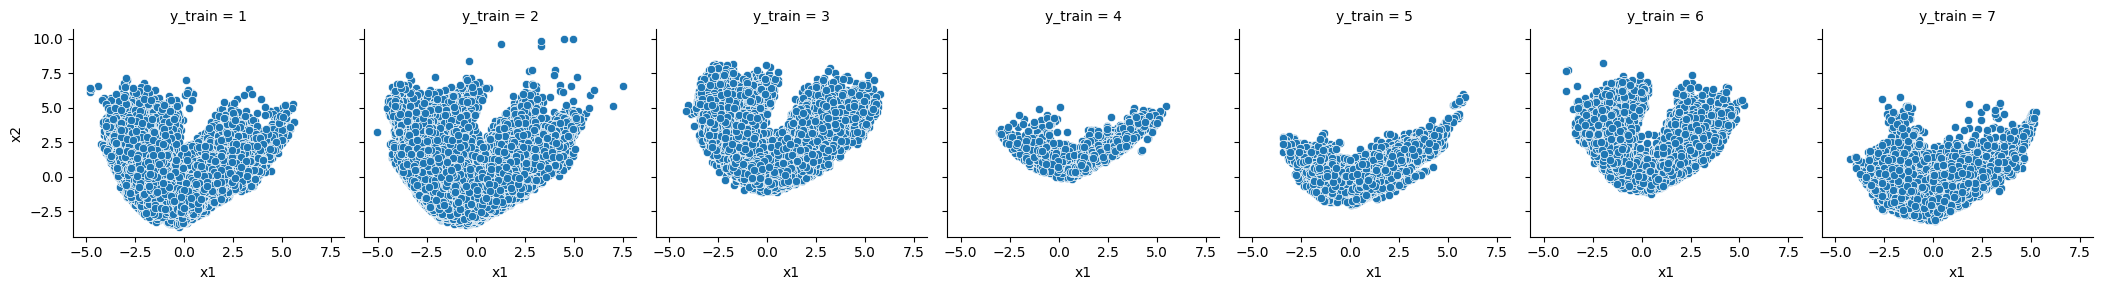

In [8]:
g = sns.FacetGrid(pca_data, col="y_train")
g.map(sns.scatterplot, 'x1', 'x2')

In [9]:
# It seems all of the variables have similar distributions when dimension is reduced by pca
# to two dimensions.

/home/chris/Desktop/cloud_practice/env/lib/python3.10/site-packages/seaborn/axisgrid.py:745: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  plot_args = [v for k, v in plot_data.iteritems()]
/home/chris/Desktop/cloud_practice/env/lib/python3.10/site-packages/seaborn/axisgrid.py:745: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  plot_args = [v for k, v in plot_data.iteritems()]
/home/chris/Desktop/cloud_practice/env/lib/python3.10/site-packages/seaborn/axisgrid.py:745: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  plot_args = [v for k, v in plot_data.iteritems()]
/home/chris/Desktop/cloud_practice/env/lib/python3.10/site-packages/seaborn/axisgrid.py:745: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  plot_args = [v for k, v in plot_data.iteritems()]
/home/chris/Desktop/

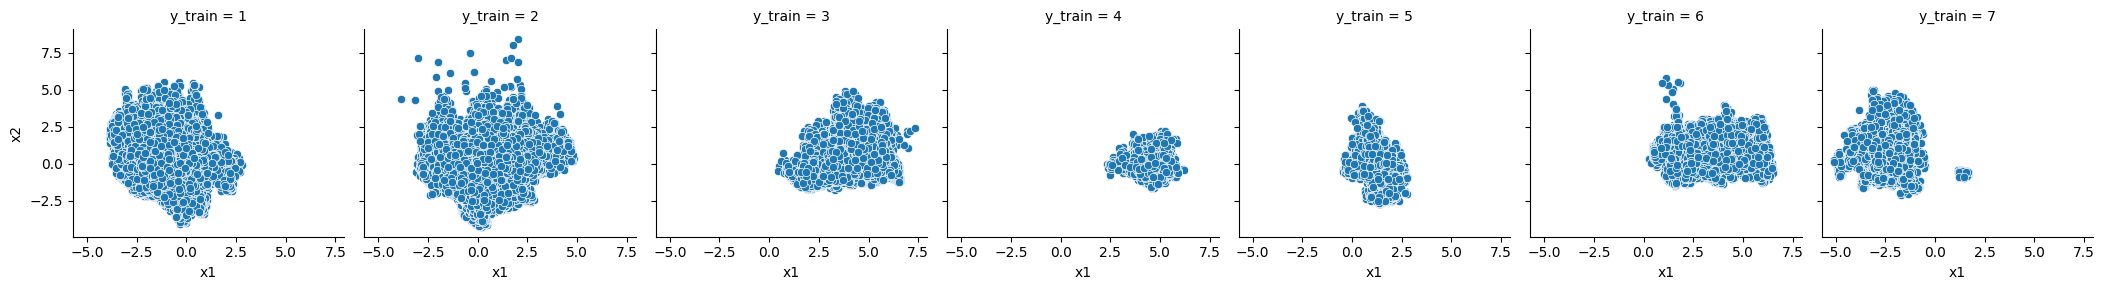

In [10]:
g = sns.FacetGrid(lda_data, col="y_train")
g.map(sns.scatterplot, 'x1', 'x2')

In [11]:
# lda is much more promising as a dimension reduction technique than pca because it 
# successfully groups the classes into more distinct areas.  Now I will grid search over 
# how many dimensions(if any) to reduce to through lda.  I will also explore whether 
# scaling before dimension reduction improves f1 score.

In [12]:
num_pipe = Pipeline([
    ("Scaler", StandardScaler()),
    ("DimReduction", PCA())
])

In [13]:
ct = ColumnTransformer([
    ("num_pipe", num_pipe, num_vars)], remainder="passthrough")

clf = HistGradientBoostingClassifier(
    categorical_features=np.ones(10, dtype=bool),
    scoring="f1_macro"
)

pipe = Pipeline([("ct", ct), ("clf", clf)])

In [14]:
# generates a parameter grid that inputs the correct number categorical mask for each 
# dimension reduction configuration
def param_grid_generator():
    param_grid = []
    for i in range(2,7):
        params = {
            "ct__num_pipe__Scaler": [StandardScaler(), MinMaxScaler(), 'passthrough'],
            "ct__num_pipe__DimReduction": [LinearDiscriminantAnalysis(n_components=i)],
            "clf__categorical_features": [np.concatenate([
                np.zeros(i, dtype=bool), np.ones(44, dtype=bool)])]
            }
        param_grid.append(params)
    for i in range(3,9):
        params = {
            "ct__num_pipe__Scaler": [StandardScaler(), MinMaxScaler(), 'passthrough'],
            "ct__num_pipe__DimReduction": [PCA(n_components=i)],
            "clf__categorical_features": [np.concatenate([
                np.zeros(i, dtype=bool), np.ones(44, dtype=bool)])]
        }
        param_grid.append(params)
    params = {
        "ct__num_pipe__Scaler": [StandardScaler(), MinMaxScaler(), "passthrough"],
        "ct__num_pipe__DimReduction": ["passthrough"],
        "clf__categorical_features": [np.concatenate(
            [np.zeros(10, dtype=bool), np.ones(44, dtype=bool)])]}
    param_grid.append(params)
    return param_grid

In [15]:
param_grid = param_grid_generator()

In [16]:
output = GridSearchCV(
    estimator=pipe, param_grid=param_grid, scoring="f1_macro", verbose=2)

In [17]:
output.fit(X_train, y_train)

Fitting 5 folds for each of 36 candidates, totalling 180 fits
[CV] END clf__categorical_features=[False False  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True], ct__num_pipe__DimReduction=LinearDiscriminantAnalysis(n_components=2), ct__num_pipe__Scaler=StandardScaler(); total time=  24.3s
[CV] END clf__categorical_features=[False False  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True], ct__num_pipe__DimReduction=LinearDiscriminantAnalysis(n_components=2), ct__num_pipe__Scaler=StandardScaler(); total time=  22.6s
[CV] END clf__categorical_features=[False Fals

GridSearchCV(estimator=Pipeline(steps=[('ct',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('num_pipe',
                                                                         Pipeline(steps=[('Scaler',
                                                                                          StandardScaler()),
                                                                                         ('DimReduction',
                                                                                          PCA())]),
                                                                         Index(['Elevation', 'Aspect', 'Slope', 'Horizontal_Distance_To_Hydrology',
       'Vertical_Distance_To_Hydrology', 'Horizontal_Distance_To_Roadways',
       'Hillshade_9am', 'Hillshade_Noo...
       False,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True])],
                          'ct__num_pipe__DimReduction': ['passthrough'],
                          'ct__num_pipe__Scaler': [StandardScaler(),
                                                   MinMaxScaler(),
                                                   'passthrough']}],
             scoring='f1_macro', verbose=2)

In [18]:
results = output.cv_results_
best_params = output.best_params_
best_score = output.best_score_
best_estimator = output.best_estimator_

In [19]:
results_df = pd.DataFrame(dict(
    # cat_features=results['param_clf__categorical_features'],
    dim_reduction=results['param_ct__num_pipe__DimReduction'],
    Scaler=results['param_ct__num_pipe__Scaler'],
    mean_score=results['mean_test_score']))

In [20]:
results_df

,dim_reduction,Scaler,mean_score
0,LinearDiscriminantAnalysis(n_components=2),StandardScaler(),0.607019
1,LinearDiscriminantAnalysis(n_components=2),MinMaxScaler(),0.596678
2,LinearDiscriminantAnalysis(n_components=2),passthrough,0.598671
3,LinearDiscriminantAnalysis(n_components=3),StandardScaler(),0.644825
4,LinearDiscriminantAnalysis(n_components=3),MinMaxScaler(),0.646796
5,LinearDiscriminantAnalysis(n_components=3),passthrough,0.651118
6,LinearDiscriminantAnalysis(n_components=4),StandardScaler(),0.675696
7,LinearDiscriminantAnalysis(n_components=4),MinMaxScaler(),0.681862
8,LinearDiscriminantAnalysis(n_components=4),passthrough,0.678670
9,LinearDiscriminantAnalysis(n_components=5),StandardScaler(),0.699473


In [21]:
# Adding 'n_numerical' column by using regex to find first number in a string
results_df['n_numerical'] = results_df['dim_reduction'].apply(
    lambda x: int(re.search(r'\d+', str(x)).group()) if 'n_components' in str(x) else 10)


In [22]:
# Dropping extra characters from dim reduction column
results_df['dim_reduction'] = results_df['dim_reduction'].apply(
    lambda x: str(x).split('(')[0])

In [23]:
# Dropping extra characters from Scaler column
results_df['Scaler'] = results_df['Scaler'].apply(
    lambda x: str(x).split('(')[0])

In [24]:
results_df

,dim_reduction,Scaler,mean_score,n_numerical
0,LinearDiscriminantAnalysis,StandardScaler,0.607019,2
1,LinearDiscriminantAnalysis,MinMaxScaler,0.596678,2
2,LinearDiscriminantAnalysis,passthrough,0.598671,2
3,LinearDiscriminantAnalysis,StandardScaler,0.644825,3
4,LinearDiscriminantAnalysis,MinMaxScaler,0.646796,3
5,LinearDiscriminantAnalysis,passthrough,0.651118,3
6,LinearDiscriminantAnalysis,StandardScaler,0.675696,4
7,LinearDiscriminantAnalysis,MinMaxScaler,0.681862,4
8,LinearDiscriminantAnalysis,passthrough,0.678670,4
9,LinearDiscriminantAnalysis,StandardScaler,0.699473,5


In [25]:
dim_reduced_df = results_df[:33].copy()
dim_reduced_df

,dim_reduction,Scaler,mean_score,n_numerical
0,LinearDiscriminantAnalysis,StandardScaler,0.607019,2
1,LinearDiscriminantAnalysis,MinMaxScaler,0.596678,2
2,LinearDiscriminantAnalysis,passthrough,0.598671,2
3,LinearDiscriminantAnalysis,StandardScaler,0.644825,3
4,LinearDiscriminantAnalysis,MinMaxScaler,0.646796,3
5,LinearDiscriminantAnalysis,passthrough,0.651118,3
6,LinearDiscriminantAnalysis,StandardScaler,0.675696,4
7,LinearDiscriminantAnalysis,MinMaxScaler,0.681862,4
8,LinearDiscriminantAnalysis,passthrough,0.678670,4
9,LinearDiscriminantAnalysis,StandardScaler,0.699473,5


In [26]:
passthrough_df = results_df[33:].copy()
passthrough_df

,dim_reduction,Scaler,mean_score,n_numerical
33,passthrough,StandardScaler,0.786685,10
34,passthrough,MinMaxScaler,0.791156,10
35,passthrough,passthrough,0.803543,10


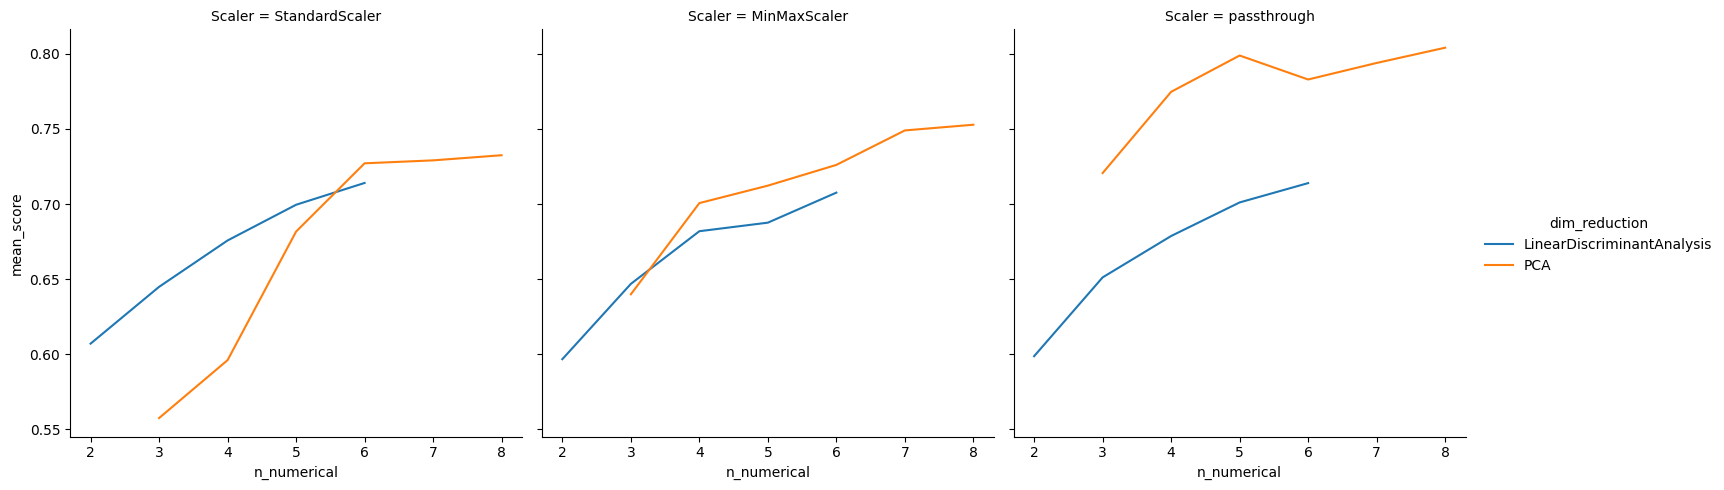

In [27]:
sns.relplot(
    data=dim_reduced_df, x="n_numerical", y="mean_score", col="Scaler", 
    hue="dim_reduction", kind="line"
)

In [28]:
# With the correct number of variables chosen, pca will outperform lda regardless of scaler
# chosen

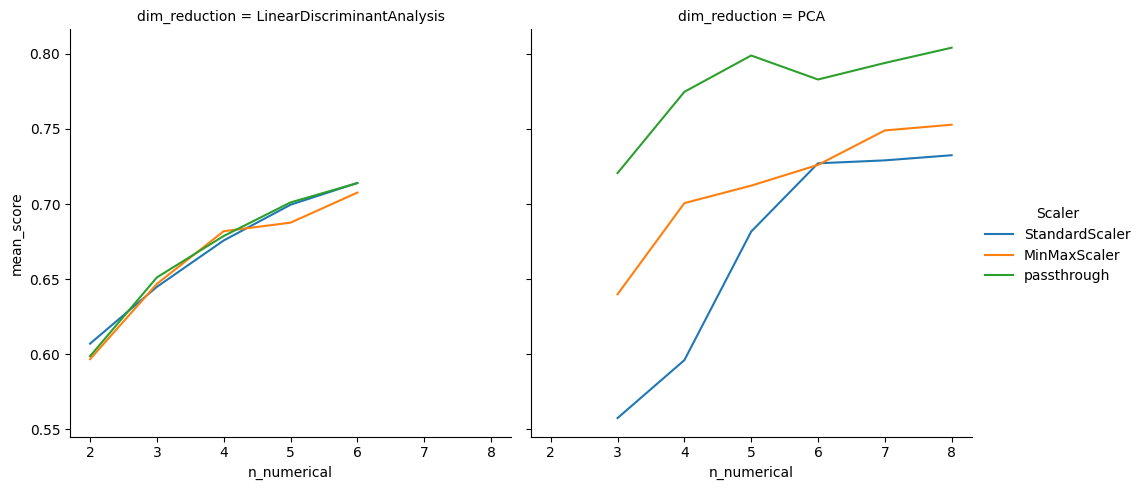

In [29]:
sns.relplot(
    data=dim_reduced_df, x="n_numerical", y="mean_score", col="dim_reduction", 
    hue="Scaler", kind="line"
)

In [30]:
# Interestingly, lda performed almost identically with all scaler options.  Pca
# on the other hand drastically improves when it is not scaled, and it seems to do a bit
# better with normalization than with standard scaling.

In [43]:
dim_reduced_df.loc[
    (dim_reduced_df["Scaler"]=="passthrough") &
    (dim_reduced_df["dim_reduction"]=="PCA")
][["dim_reduction", "mean_score", "n_numerical"]]

,dim_reduction,mean_score,n_numerical
17,PCA,0.720569,3
20,PCA,0.774653,4
23,PCA,0.798822,5
26,PCA,0.782857,6
29,PCA,0.793871,7
32,PCA,0.804021,8


In [47]:
# PCA with 7 and 8 components both outperform the average of 5 gridsearch rounds that was
# tested in another notebook.  However, I will need to test these two candidate models 
# with the same 5 rounds to truly see which parameters I want to select.  The average 
# of 5 grid search rounds for no scaling and no dimension reduction from the previous
# notebook was 79%.

In [63]:
num_pipe = Pipeline([
    ("Scaler", "passthrough"),
    ("DimReduction", PCA(n_components=7))
])

In [64]:
ct = ColumnTransformer([
    ("num_pipe", num_pipe, num_vars)], remainder="passthrough")

clf = HistGradientBoostingClassifier(
    categorical_features=np.ones(10, dtype=bool),
    scoring="f1_macro"
)

pipe = Pipeline([("ct", ct), ("clf", clf)])

In [67]:
def n_components_experiment():
    results_list = []
    for n_components in range(7, 9):    
        for i in range(5):
            param_grid = {
                "ct__num_pipe__DimReduction": [PCA(n_components=n_components)],
                "clf__categorical_features": [np.concatenate([
                np.zeros(n_components, dtype=bool), np.ones(44, dtype=bool)])]
            }
            output = GridSearchCV(estimator=pipe, param_grid=param_grid, scoring="f1_macro")
            output.fit(X_train, y_train)
            results = output.cv_results_
            results_list.append(results)
    return results_list


In [68]:
results_list = n_components_experiment()

In [101]:
results_df = pd.DataFrame(columns=["n_components", "mean_score"])
for result in results_list:
    results_df.loc[len(results_df.index)] = [result["param_ct__num_pipe__DimReduction"][0],
        result["mean_test_score"][0]]

In [102]:
results_df

,n_components,mean_score
0,PCA(n_components=7),0.808935
1,PCA(n_components=7),0.804316
2,PCA(n_components=7),0.783972
3,PCA(n_components=7),0.791617
4,PCA(n_components=7),0.803441
5,PCA(n_components=8),0.801438
6,PCA(n_components=8),0.799978
7,PCA(n_components=8),0.799590
8,PCA(n_components=8),0.789569
9,PCA(n_components=8),0.800874


In [105]:
results_df["n_components"] = results_df["n_components"].apply(
    lambda x: re.search(r'\d+', str(x)).group())

In [106]:
results_df

,n_components,mean_score
0,7,0.808935
1,7,0.804316
2,7,0.783972
3,7,0.791617
4,7,0.803441
5,8,0.801438
6,8,0.799978
7,8,0.799590
8,8,0.789569
9,8,0.800874


In [107]:
results_df.groupby("n_components").mean()

,mean_score
n_components,
7,0.798456
8,0.798290


In [ ]:
# For our purposes, the mean scores for 7 and 8 components are virtually identical, 
# differeing only by less than 0.02%.  Both of these scores are over 0.8% higher than the 
# 79% from the experiment involving no scaling or dimension reduction.  Although this is
# not very significant, I will choose a pca model.  I will choose 8 components rather
# than 7 just because I want to.